In [22]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import multiprocessing
import numpy as np

In [23]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
# Define stop words
stop_words = stopwords.words('english')

In [25]:
# Define text cleaning and tokenizing functions
def clean_text(txt: str):
    '''Clean and lower case text.'''
    txt = re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())
    txt = re.sub(r"\b\d+\b", "", txt).strip()
    return txt

def tokenizer(txt: str):
    '''Custom tokenizer.'''
    tokens = []

    # split strings into sentences
    for sent in sent_tokenize(txt, language='english'):
        # split each sentence into tokens and apply text cleaning
        for word in word_tokenize(clean_text(sent), language='english'):
            if len(word) < 2:  # remove short words
                continue
            if word in stop_words:  # remove stop words
                continue
            tokens.append(word)

    return tokens

In [26]:
# Load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [27]:
# Tokenize the text
tokenized_text_train = [tokenizer(doc) for doc in newsgroups_train.data]
tokenized_text_test = [tokenizer(doc) for doc in newsgroups_test.data]

In [28]:
# Create Word2Vec and Doc2Vec models
dim_w2v = 200  # Dimensionality of word vectors
alpha = 0.025  # Initial learning rate
alpha_min = 0.0001  # Drop learning rate to this value
wnd = 5        # Window size (max. distance to predicted word)
mincount = 2   # Word frequency lower bound
sample = 1e-5  # Threshold for downsampling
sg = 1         # Index 1 => Skip-Gram algo.
ngt = 10       # No. noisy words for negative sampling
epochs = 5     # No. epochs for training
cpus = multiprocessing.cpu_count()  # Tot. no. of CPUs
threads = cpus -1  # Use this number of threads for training


In [10]:
w2v_model = Word2Vec(
    sentences=tokenized_text_train, vector_size=dim_w2v, alpha=alpha, min_alpha=alpha_min, window=wnd,
    min_count=mincount, sample=sample, sg=sg, negative=ngt, epochs=epochs, workers=threads
)

In [11]:
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_text_train)]
doc2vec_model = Doc2Vec(tagged_data, vector_size=dim_w2v, window=wnd, min_count=mincount, workers=threads)

In [31]:
# Transform text data into vectors, handling OOV words
X_train_word2vec = [[w2v_model.wv[word] for word in doc if word in w2v_model.wv] for doc in tokenized_text_train]
X_train_doc2vec = [doc2vec_model.infer_vector(word) for word in tokenized_text_train]

In [29]:
# Define algorithms
algorithms = {
    'Multinomial Naïve Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machines': svm.SVC(),
    'Decision Trees': DecisionTreeClassifier()
}

feature_extractors = {
    'CountVectorizer': CountVectorizer(),
}

In [15]:
# Store results
results = []

In [40]:
# For each algorithm
for algo_name, algo in algorithms.items():
    for fe_name, X_train in [('Word2Vec', X_train_word2vec), ('Doc2Vec', X_train_doc2vec)]:
        # Skip MultinomialNB for Word2Vec and Doc2Vec
        if algo_name == 'Multinomial Naïve Bayes' and fe_name in ['Word2Vec', 'Doc2Vec']:
            continue

        # Train model
        if fe_name == 'Word2Vec':
            # Average word vectors for each document
            X_train_avg = np.array([np.mean([w2v_model.wv[word] for word in doc if word in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for doc in tokenized_text_train])
            algo.fit(X_train_avg, newsgroups_train.target)
        else:  # Doc2Vec
            X_train_arr = np.array([doc2vec_model.infer_vector(doc) for doc in tokenized_text_train])
            algo.fit(X_train_arr, newsgroups_train.target)

        # Transform test data
        if fe_name == 'Word2Vec':
            X_test_avg = np.array([np.mean([w2v_model.wv[word] for word in doc if word in w2v_model.wv] or [np.zeros(w2v_model.vector_size)], axis=0) for doc in tokenized_text_test])
        else:  # Doc2Vec
            X_test_arr = np.array([doc2vec_model.infer_vector(doc) for doc in tokenized_text_test])

        # Predict
        y_pred = algo.predict(X_test_avg if fe_name == 'Word2Vec' else X_test_arr)

        # Calculate metrics
        accuracy = accuracy_score(newsgroups_test.target, y_pred)
        recall = recall_score(newsgroups_test.target, y_pred, average='macro')
        f1 = f1_score(newsgroups_test.target, y_pred, average='macro')

        # Store results
        results.append({
            'Algorithm': algo_name,
            'Feature Extractor': fe_name,
            'Accuracy': f"{accuracy * 100:.3f}%",
            'Recall': f"{recall * 100:.3f}%",
            'F1 Score': f"{f1 * 100:.3f}%"
        })


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

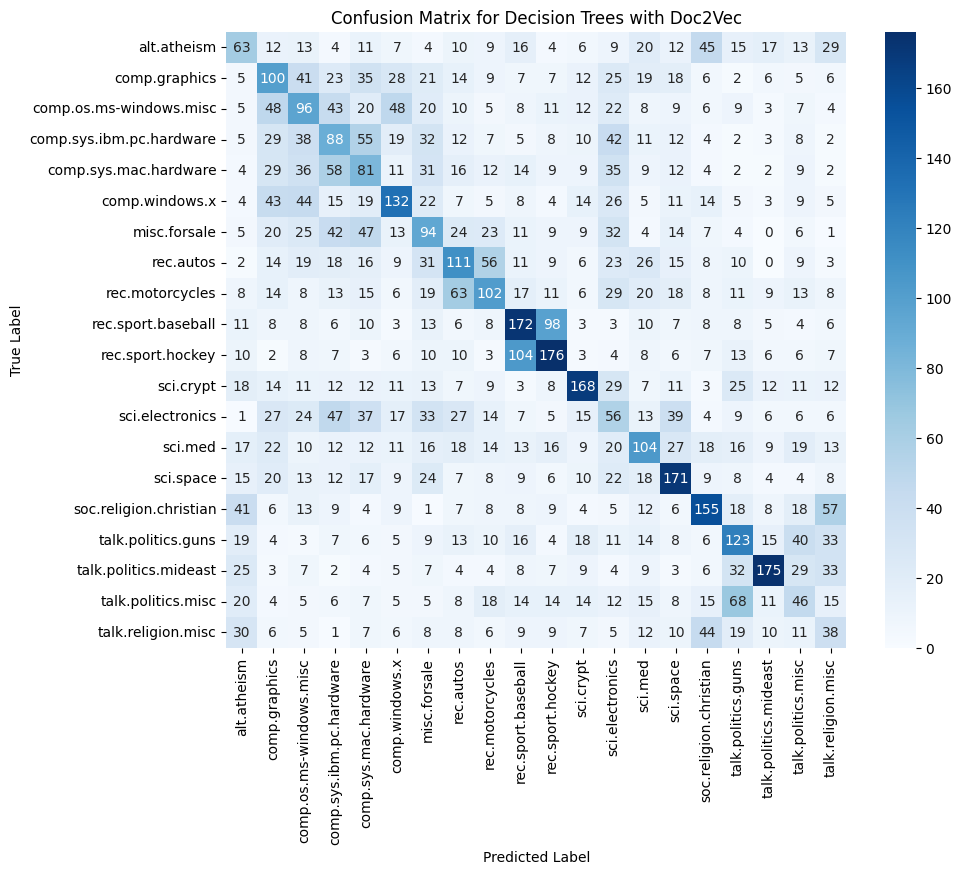

                 Algorithm Feature Extractor Accuracy   Recall F1 Score
0      Logistic Regression          Word2Vec  61.458%  60.662%  60.361%
1      Logistic Regression           Doc2Vec  67.153%  66.073%  66.012%
2  Support Vector Machines          Word2Vec  56.665%  55.919%  56.392%
3  Support Vector Machines           Doc2Vec  66.423%  65.104%  64.747%
4           Decision Trees          Word2Vec  44.596%  44.471%  44.696%
5           Decision Trees           Doc2Vec  29.886%  29.376%  29.538%


In [41]:
# Compute confusion matrix
cm = confusion_matrix(newsgroups_test.target, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=newsgroups_train.target_names, yticklabels=newsgroups_train.target_names)
plt.title(f'Confusion Matrix for {algo_name} with {fe_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Convert results to DataFrame
df = pd.DataFrame(results)

# Print results
print(df)